### Trabalho 4 - Robótica Movel - MO651
#### __Professor(a):__ _Esther Luna Columbini_ <br>
__Alunos:__ <br>
_Tito Barbosa Rezende_              __RA:__ 025327<br>
_João Paulo_                        __RA:__ 229322<br>
_Elcio Pereira de Souza Junior_     __RA:__ 262952

### Pré-requisitos

Instalação das bibliotecas necessárias.

In [ ]:
%pip install matplotlib
%pip install numpy
%pip install opencv-python
%pip install sklearn
%pip install pwlf
%pip install gpyopt
%pip install pypng

In [17]:
import sys, time
sys.path.insert(0, '../src')
from robot import Robot
import utils
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np
import vrep
import math
import multiprocessing
import random
from datetime import datetime
import lidar_to_grid_map as lg
import grid_map_lib as gm
import operator
import asyncio
#import png

### Definindo objeto robô

Nos próximos passos será instanciado o objeto robô, este será utilizado durante todo o projeto. Também serão realizados uma série de testes de conexão com a API.


In [18]:
robot = Robot()

Connected to remoteApi server.
 Pioneer_p3dx_ultrasonicSensor1 connected.
 Pioneer_p3dx_ultrasonicSensor2 connected.
 Pioneer_p3dx_ultrasonicSensor3 connected.
 Pioneer_p3dx_ultrasonicSensor4 connected.
 Pioneer_p3dx_ultrasonicSensor5 connected.
 Pioneer_p3dx_ultrasonicSensor6 connected.
 Pioneer_p3dx_ultrasonicSensor7 connected.
 Pioneer_p3dx_ultrasonicSensor8 connected.
 Pioneer_p3dx_ultrasonicSensor9 connected.
 Pioneer_p3dx_ultrasonicSensor10 connected.
 Pioneer_p3dx_ultrasonicSensor11 connected.
 Pioneer_p3dx_ultrasonicSensor12 connected.
 Pioneer_p3dx_ultrasonicSensor13 connected.
 Pioneer_p3dx_ultrasonicSensor14 connected.
 Pioneer_p3dx_ultrasonicSensor15 connected.
 Pioneer_p3dx_ultrasonicSensor16 connected.
 Vision sensor connected.
 Laser connected.
 Gyro connected.
 Left motor connected.
 Right motor connected.
 Robot connected.


In [19]:
robot.read_gyroAngle()

[-7.657968671992421e-05, -0.001991116674616933, 0.0002975640236400068]

In [20]:
robot.set_right_velocity(-5)
time.sleep(10)
robot.stop()

## Modelo Cinemático

### Sensor Laser

Nesta etapa definimos a classe para leitura dos dados que serão obtidos pelo sensor laser, e realizamos uma verificação sobre a obtenção destes dados.

In [21]:
class Laser_sensor:
    def __init__(self,robot):
        self.robot = robot

    def update_robot_frame_reading(self):
        laser_flatten_readings = np.array(self.robot.read_laser())
        laser_readings = laser_flatten_readings.reshape((len(laser_flatten_readings)//3, 3))
        self.laser_x = laser_readings[:,0]
        self.laser_y = laser_readings[:,1]

    def plot_laser_robot_frame(self):
#     fig, ax = plt.subplots()
#     #posição dos feixes laser
#     ax.scatter(laser_sensor.laser_x, laser_sensor.laser_y, 3, c='g', marker='o')
#     #posição do centro do robo
#     ax.scatter(0, 0, 40, c='b', marker='o')
#     plt.show()
        ox = self.laser_x
        oy = self.laser_y
        plt.figure(figsize=(6,10))
        plt.plot([oy, np.zeros(np.size(oy))], [ox, np.zeros(np.size(oy))], "ro-") # lines from 0,0 to the 
        plt.axis("equal")
        bottom, top = plt.ylim()  # return the current ylim
        plt.ylim((top, bottom)) # rescale y axis, to match the grid orientation
        plt.grid(True)
        plt.show()
        
    def plot_grid_fill(self):
        xyreso = 0.02  # x-y grid resolution
        #yawreso = math.radians(3.1)  # yaw angle resolution [rad]
        
        ox = self.laser_x
        oy = self.laser_y
        pmap, minx, maxx, miny, maxy, xyreso = lg.generate_ray_casting_grid_map(ox, oy, xyreso, False)
        xyres = np.array(pmap).shape
        plt.figure(figsize=(20,8))
        plt.subplot(122)
        plt.imshow(pmap, cmap = "PiYG_r") 
        plt.clim(-0.4, 1.4)
        plt.gca().set_xticks(np.arange(-.5, xyres[1], 1), minor = True)
        plt.gca().set_yticks(np.arange(-.5, xyres[0], 1), minor = True)
        plt.grid(True, which="minor", color="w", linewidth = .6, alpha = 0.5)
        plt.colorbar()
        plt.show()
         
    
laser_sensor = Laser_sensor(robot)
laser_sensor.update_robot_frame_reading()

Verificação dos dados brutos coletados

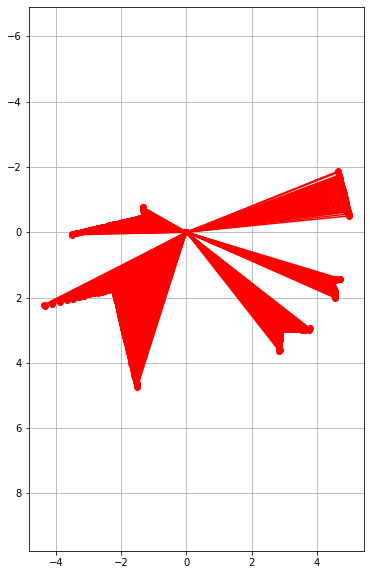

In [22]:
laser_sensor.plot_laser_robot_frame()

In [23]:
laser_sensor.plot_grid_fill()

The grid map is  550 x 650 .


ValueError: too many values to unpack (expected 6)

Vamos mudar a posição do robo e ler novamente

### Sensor Ultrassônico

Para obter a leitura correta dos sensores de proximidade, precisamos transformar a leitura do sensor em um ponto _(x,y)_ em relação ao frame do robo.


In [24]:
class Us_sensor:
    def __init__(self,robot):
        orientation_angles = np.array([90,50,30,10,-10,-30,-50,-90,-90,-130,-150,-170,170,150,130,90])
        orientation_rad = np.radians(orientation_angles)
        self.data = {
        "prefix" : "Pioneer_p3dx_ultrasonicSensor",
        "ids" : np.arange(1,17,1), "handles" : np.zeros(16, dtype=int), 
        "positions" :  np.zeros((16,3),dtype=float),
        "angles_deg": orientation_angles,
        "angles_rad": orientation_rad,
        "raw_reading": np.zeros(16),
        "robot_frame_reading": np.zeros((16,2),dtype=float)
        }
        self.robot = robot
        
        for i,sensor_i in enumerate(self.data['ids']):
            ret,handle = vrep.simxGetObjectHandle(self.robot.clientID, self.data['prefix'] + str(sensor_i), vrep.simx_opmode_oneshot_wait)
            self.data['handles'][i] = handle
            ret, pos = vrep.simxGetObjectPosition(self.robot.clientID, handle, self.robot.robot_handle, vrep.simx_opmode_oneshot_wait)
            #ret, ang = vrep.simxGetObjectOrientation(robot.clientID, handle, robot.robot_handle, vrep.simx_opmode_oneshot_wait)
            self.data['positions'][i,:] = pos
            #ultrassonic_sensors[sensor_i,4:7] = ang
    
    def update_raw_reading(self):
        self.data["raw_reading"] = np.array(self.robot.read_ultrassonic_sensors())
    
    def update_robot_frame_reading(self):
        self.update_raw_reading()
        for i, proximity in enumerate(us_sensors.data["raw_reading"]):
            if proximity == 5 or proximity < 0.1:
                self.data["robot_frame_reading"][i] = np.zeros(2)
            else:
                self.data["robot_frame_reading"][i] = self.proximity_robot_frame(i+1,proximity).flatten()
                
        #toRobotFrame = lambda sensorId,proximity: self.proximity_robot_frame(sensorId,proximity)
        #self.data["robot_frame_reading"] = toRobotFrame(range(1,17,1),us_sensors.data["raw_reading"])
    
    #Calcula o ponto no frame do robo, referente a leitura de cada sensor de proximidade
    def proximity_robot_frame(self,sensorId, proximity):
        index = sensorId -1
        angulars = self.data["angles_rad"][index]
        #Matriz de rotação
        rot_matrix = np.array([[math.cos(angulars),-math.sin(angulars)],[math.sin(angulars),math.cos(angulars)]])
        #Rotacionando a leitura
        distXY = np.dot(rot_matrix , np.array([[proximity],[0]]))
        #Matriz de translação
        posicao_sensor_x = self.data["positions"][index][0]
        posicao_sensor_y = self.data["positions"][index][1]
        transXY=np.array([[distXY[0][0]+posicao_sensor_x],[distXY[1][0]+posicao_sensor_y]])
        return transXY
    
    def plot_us_robot_frame(self):
        fig, ax = plt.subplots()
        #posição dos sensores US
        ax.scatter(self.data['positions'][:,0], self.data['positions'][:,1], 10, c='r', marker='o')
        #posição do centro do robo
        ax.scatter(0, 0, 40, c='b', marker='o')
        #posição dos pontos lidos pelo sensor ultrassonico
        ax.scatter(self.data['robot_frame_reading'][:,0], self.data['robot_frame_reading'][:,1], 10, c='black', marker='.')
        plt.show()

us_sensors = Us_sensor(robot)

Definimos uma função _toGlobal_ (para termos um melhor reuso de código), basicamente a função transforma um ponto qualquer _(x,y)_ que esteja na referência do robô e o leva para a referência global.

In [25]:
def toGlobal(robot_x, robot_y,robot_ang, Point_xr, Point_yr):
    T_trans = np.array([[1,0,robot_x],[0,1,robot_y],[0,0,1]])
    T_rot = np.array([[math.cos(robot_ang),-math.sin(robot_ang),0],[math.sin(robot_ang),math.cos(robot_ang),0],[0,0,1]])
    T = np.dot(T_trans,T_rot)
    res = np.dot(T, np.array([Point_xr,Point_yr,1]))
    return res[0],res[1]

## Modelo Cinemático

Dado o movimento do robo, como determinar sua posição e orientação no frame global?

In [26]:
class Kinematic_model:
    def __init__(self,robot):
        self.robot = robot
        
        #Handles dos motores
        ret1, self.motorLeft = vrep.simxGetObjectHandle(self.robot.clientID, "Pioneer_p3dx_leftMotor", vrep.simx_opmode_oneshot_wait)
        ret2, self.motorRight = vrep.simxGetObjectHandle(self.robot.clientID, "Pioneer_p3dx_rightMotor", vrep.simx_opmode_oneshot_wait)
        
        #Calcula distancia de eixo
        res, left_handle = vrep.simxGetObjectHandle(robot.clientID, "Pioneer_p3dx_leftMotor", vrep.simx_opmode_oneshot_wait)
        ret, lpos = vrep.simxGetObjectPosition(robot.clientID, left_handle, robot.robot_handle, vrep.simx_opmode_oneshot_wait)
        ret,jL = vrep.simxGetJointPosition(self.robot.clientID,self.motorLeft,vrep.simx_opmode_streaming)
        
        res, right_handle = vrep.simxGetObjectHandle(robot.clientID, "Pioneer_p3dx_rightMotor", vrep.simx_opmode_oneshot_wait)
        ret, rpos = vrep.simxGetObjectPosition(robot.clientID, right_handle, robot.robot_handle, vrep.simx_opmode_oneshot_wait)
        ret,jR = vrep.simxGetJointPosition(self.robot.clientID,self.motorRight,vrep.simx_opmode_streaming)
       
        # eixo
        self.l = (abs(lpos[1]) + abs(rpos[1]))/2
        
        #Ao ser criado, coleta a referencia de zero do robo
        pos = self.robot.get_current_position()
        self.initial_pos_x = pos[0]
        self.initial_pos_y = pos[1]
        orientation = self.robot.get_current_orientation()
        self.initial_orientation = orientation[2]

        #Alem de mantermos a pose inicial, manteremos a pose atualizada do robo
        self.enc_global_x = self.initial_pos_x
        self.enc_global_y = self.initial_pos_y
        self.enc_Theta = self.initial_orientation
        
        self.time_global_x = self.initial_pos_x
        self.time_global_y = self.initial_pos_y
        self.time_Theta = self.initial_orientation
        
        #Lista de pontos para o caminho do robo
        self.enc_path = []
        self.time_path = []
        self.true_path = []
        self.update_paths()
        
        #inicializando a posição dos encoders
        self.jL = self.current_encoder_left()
        self.jR = self.current_encoder_right()
        
        #intervalo entre cada calculo
        self.compute_interval = 0.1
        self.previous_timestamp = 0
        
    def update_paths(self):
        self.enc_path.append([self.enc_global_x, self.enc_global_y, self.enc_Theta])
        self.time_path.append([self.time_global_x, self.time_global_y, self.time_Theta])
        orientation = self.robot.get_current_orientation()
        true_theta = orientation[2]
        current_position = self.true_global_position()
        self.true_path.append([current_position[0], current_position[1], true_theta])
    
    def true_global_position(self):
        pos = self.robot.get_current_position()
        return pos[0],pos[1]
    
    def enc_global_position(self):
        return self.enc_global_x, self.enc_global_y, self.enc_Theta
    
    def time_global_position(self):
        return self.time_global_x, self.time_global_y, self.time_Theta
    
    
    ##Esta seção esta relacionada ao calculo da posição levando em consideração os encoders
    def current_encoder_left(self):
        ret,jL = vrep.simxGetJointPosition(self.robot.clientID,self.motorLeft,vrep.simx_opmode_buffer)
        return jL
    def current_encoder_right(self):
        ret, jR = vrep.simxGetJointPosition(self.robot.clientID,self.motorRight,vrep.simx_opmode_buffer)
        return jR
        
    #Phi speed of rotation of wheels
    def Xr(self, Phi_right, Phi_left):
        r = self.robot.WHEEL_RADIUS
        Xr = (r*Phi_left/2) + (r*Phi_right/2)
        return Xr
    
    def Theta_r(self, Phi_right, Phi_left):
        r = self.robot.WHEEL_RADIUS
        Tr = r*Phi_right/(2*self.l) - r*Phi_left/(2*self.l) 
        return Tr
        
    def speed_model(self,Phi_right,Phi_left):
        #Se formos considerar que o eixo das rodas do robo está deslocado do eixo x
        #return np.array([self.Xr(Phi_right,Phi_left),self.Theta_r(Phi_right,Phi_left)*self.l2,self.Theta_r(Phi_right,Phi_left)])
        return np.array([self.Xr(Phi_right,Phi_left),0,self.Theta_r(Phi_right,Phi_left)])
        
    def inverse_rotation_matrix(self, ang):
        Trot = np.array([[math.cos(ang), -math.sin(ang), 0], [math.sin(ang), math.cos(ang), 0], [0,0,1]])
        return Trot
    
    def locomotion_global(self, ang, Phi_right, Phi_left):
        return np.dot(self.inverse_rotation_matrix(ang),self.speed_model(Phi_right,Phi_left))
    
    def compute_with_encoder(self):
        dxR = self.current_encoder_right() - self.jR
        dxL = self.current_encoder_left() - self.jL
        if (dxL>=0):
            dxL=math.fmod(dxL+math.pi,2*math.pi)-math.pi
        else:
            dxL=math.fmod(dxL-math.pi,2*math.pi)+math.pi
        if (dxR>=0):
            dxR=math.fmod(dxR+math.pi,2*math.pi)-math.pi
        else:
            dxR=math.fmod(dxR-math.pi,2*math.pi)+math.pi
        qsi = self.locomotion_global(self.enc_Theta,dxR, dxL)
        #Atualiza a posição global
        self.enc_global_x = self.enc_global_x + qsi[0]
        self.enc_global_y = self.enc_global_y + qsi[1]
        
        #Without gyroscope
        #self.enc_Theta = self.enc_Theta + qsi[2]
        #with gyroscope
        self.enc_Theta = self.robot.read_gyroAngle()[2]
        
        #Atualiza a posição dos encoders
        self.jR = self.current_encoder_right()
        self.jL = self.current_encoder_left()
    ##Fim da seção relacionada ao calculo da posição levando em consideração os encoders        
    
    def compute_with_time(self, Phi_right, Phi_left):
        #Calculo do delta S
        r = self.robot.WHEEL_RADIUS
        Vr = r*Phi_right
        Vl = r*Phi_left
        current_timestamp = datetime.timestamp(datetime.now())
        Delta_t = current_timestamp - self.previous_timestamp
        #atualiza timestamp imediatamente

        self.previous_timestamp = current_timestamp
        
        Delta_s = (Vr + Vl)*Delta_t/2  
        Delta_Theta = (Vr - Vl)*Delta_t/(2*self.l)
    
        self.time_global_x = self.time_global_x + Delta_s*math.cos(self.time_Theta + Delta_Theta/2)
        self.time_global_y = self.time_global_y + Delta_s*math.sin(self.time_Theta + Delta_Theta/2)
        self.time_Theta = self.time_Theta + Delta_Theta
    
    def move(self,Phi_right, Phi_left,seconds): #velocidade em rad/s
        #Vamos fixar um tempo de 500ms para computar as distâncias
        for step in range(int(seconds/self.compute_interval)):
            #self.compute()
            self.robot.set_right_velocity(Phi_right)
            self.robot.set_left_velocity(Phi_left)
            time.sleep(self.compute_interval)
            self.compute_with_encoder()
            self.compute_with_time(Phi_right, Phi_left)
            self.update_paths()
        self.robot.stop()
        self.timestamp = 0
        
    def ICR_left(self, Phi_left, R, seconds):
        Phi_right = Phi_left*(R + self.l)/(R - self.l)
        print("ICR_left Phi_r {} Phi_l {}".format(Phi_right, Phi_left))
        self.move(Phi_right, Phi_left, seconds)
    
    def ICR_right(self, Phi_right, R, seconds):
        Phi_left = Phi_right*(R + self.l)/(R - self.l)
        print("ICR_right Phi_r {} Phi_l {}".format(Phi_right, Phi_left))
        self.move(Phi_right, Phi_left, seconds)
        
    def plot_paths(self):
        enc_path = np.array(self.enc_path)
        time_path = np.array(self.time_path)
        true_path = np.array(self.true_path)
        
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
        ax.plot(enc_path[:,0], enc_path[:,1], 1, c='b', label='odometry')
        #ax[1].scatter(time_path[:,0], time_path[:,1], 5, c='g', marker='o')
        ax.plot(true_path[:,0], true_path[:,1], 1, c='r', label='true path')
        ax.legend()

Para esta implementação, o grupo se baseou nas técnicas discutidas em sala de aula.

## Nuvem de pontos

Para a nuvem de pontos, nós coletamos os dados fornecidos pelo laser (conjunto de pontos) que estão baseados no sistema de referência do robô, após aplicamos a transformação destes pontos para o sistema de referência global. Dados os pontos no sistema global nós realizamos a plotagem dos mesmos.

In [92]:
class PointCloud():
    def __init__(self, robot, us_sensors, laser_sensor):
        self.grid_map = None
        self.robot = robot
        self.us_sensors = us_sensors
        self.laser_sensor = laser_sensor
        self.res = 0.1
        
        self.ultrassonic_points = []
        self.laser_points = []
        self.robot_points = []
        
        self.gridMapPosPoints = []
    
    def update(self):
        #Insere posição atual do robo
        robot_x = self.robot.get_current_position()[0]
        robot_y = self.robot.get_current_position()[1]
        robot_ang = self.robot.get_current_orientation()[2]
        
        self.robot_points.append([robot_x,robot_y])

        #Atualiza a leitura do laser e insere na nuvem de pontos
        self.laser_sensor.update_robot_frame_reading()
        for pointx, pointy in zip(self.laser_sensor.laser_x, self.laser_sensor.laser_y):
            x,y = toGlobal(robot_x, robot_y,robot_ang, pointx, pointy)
            self.laser_points.append([x,y])

        #Atualiza a leitura do ultrassonico e insere na nuvem de pontos
        self.us_sensors.update_robot_frame_reading()
        for pointx, pointy in zip(self.us_sensors.data['robot_frame_reading'][:,0], self.us_sensors.data['robot_frame_reading'][:,1]):
            x,y = toGlobal(robot_x, robot_y,robot_ang, pointx, pointy)
            self.ultrassonic_points.append([x,y])
    
    def plot_point_cloud(self):
        #Convertendo a nuvem de pontos em um array
        ultrassonic_point_array = np.array(self.ultrassonic_points)
        laser_point_array = np.array(self.laser_points)
        robot_path = np.array(self.robot_points)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        #posição do centro do robo
        ax[0].scatter(robot_path[:,0], robot_path[:,1], 40, c='b', marker='o')
        #ax[0].plot(robot_path[:,0], robot_path[:,1],'.-')
        pass_count = 0
        for x, y in zip(robot_path[:,0], robot_path[:,1]):
            ax[0].text(x, y, str(pass_count), color="black", fontsize=12)
            pass_count += 1
        #posição dos pontos lidos pelo sensor ultrassonico
        ax[0].scatter(ultrassonic_point_array[:,0],ultrassonic_point_array[:,1], 10, c='magenta', marker='.')

        #posição do centro do robo
        ax[1].scatter(robot_path[:,0], robot_path[:,1], 40, c='b', marker='o')
        #ax[1].plot(robot_path[:,0], robot_path[:,1],'.-')
        pass_count = 0
        for x, y in zip(robot_path[:,0], robot_path[:,1]):
            ax[1].text(x, y, str(pass_count), color="black", fontsize=12)
            pass_count += 1
        #posição dos pontos lidos pelo sensor laser
        ax[1].scatter(laser_point_array[:,0],laser_point_array[:,1], 10, c='r', marker='.')

        plt.show()
          
    def set_resolution(self, resolution):
        self.res = resolution
        
    def compute_grid_ocupation(self):
        xyreso = self.res  # x-y grid resolution
        #yawreso = math.radians(3.1)  # yaw angle resolution [rad]
        #ang, dist = file_read("lidar01.csv")
        laser_point_array = np.array(self.laser_points)
        ox = laser_point_array[:,0]
        oy = laser_point_array[:,1]
        self.pmap, self.minx, self.maxx, self.miny, self.maxy, self.xyreso, self.centix, self.centiy = lg.generate_ray_casting_grid_map(ox, oy, xyreso, True)
        self.gridwidth = np.array(self.pmap).shape[0]
        self.gridheight = np.array(self.pmap).shape[1]
        self.grid_map = gm.GridMap( self.gridwidth, self.gridheight, self.res,
                 self.centix, self.centiy, init_val= self.pmap)
        
    def get_idx_from_pos(self, x, y):
        ix = int(round((x - self.minx) / self.xyreso)) # x coordinate of the the occupied area
        iy = int(round((y - self.miny) / self.xyreso)) # y coordinate of the the occupied area
        return ix, iy
    
    def get_pos_from_idx(self, idx, idy):
        x = round((idx*self.xyreso) + self.minx, 2)
        y = round((idy*self.xyreso) + self.miny, 2)
        return x, y
            
    def plot_grid_ocupation(self):
        robotX, robotY = self.get_idx_from_pos(self.robot_points[-1][0],self.robot_points[-1][1])
        print(robotX, robotY)
        self.pmap[robotX][robotY] = 0.5
        plt.figure(figsize=(20,8))
        plt.subplot(122)
        plt.imshow(self.pmap.T, cmap = "PiYG_r") 
        plt.clim(-0.4, 1.4)
        plt.gca().set_xticks(np.arange(-.5, self.gridwidth, 1), minor = True)
        plt.gca().set_yticks(np.arange(-.5, self.gridheight, 1), minor = True)
        plt.gca().invert_yaxis()
        plt.grid(True, which="minor", color="w", linewidth = .6, alpha = 0.5)
        plt.colorbar()
        plt.show()
    
    def update_grid_map_pos_points(self):
        self.gridMapPosPoints = []
        indexes = np.where(self.pmap == -1)
        for index in range(len(indexes[0])):
            idx_x = indexes[0][index]
            idx_y = indexes[1][index]
            self.gridMapPosPoints.append(self.get_pos_from_idx(idx_x, idx_y))
    
    def plot_grid_map_pos_points(self):
        point_array = np.array(self.gridMapPosPoints)
        plt.scatter(point_array[:,0],point_array[:,1], 10, c='r', marker='.')
        plt.axis('equal')
        plt.show()
        

point_cloud = PointCloud(robot, us_sensors, laser_sensor)

In [65]:
point_cloud.update()
point_cloud.plot_point_cloud()

KeyboardInterrupt: 

In [ ]:
point_cloud.compute_grid_ocupation()
point_cloud.plot_grid_ocupation()

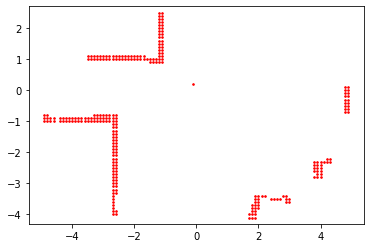

In [33]:
point_cloud.update_grid_map_pos_points()
point_cloud.plot_grid_map_pos_points()

In [34]:
class FeatureExtraction():
    def __init__(self):
        self.clusters = []
        self.line_features = {}
    
    def extract(self, data_points):
        self.line_features = {}
        self.clusters = self.clusterize(data_points)
        for i, cluster in enumerate(self.clusters):
            _, segments = self.find_segments(cluster, mode="ransac")
            self.line_features[i] =  segments
        
        new_points = []
        for d in list(feature_extraction.line_features.values()):
            for dd in list(d.values()):
                values = [ a.tolist() for a in dd ]
                new_points.extend(values)
        return new_points
            
    def plot_line_features(self):
        
        for c, cluster in enumerate(self.line_features):
            print(self.line_features[cluster])
            for l, line in enumerate(self.line_features[cluster]):
                plt.scatter(self.clusters[c][:,0], self.clusters[c][:,1], color=np.random.rand(3,), marker='.', label='cluster {}'.format(c))
                plt.plot(self.line_features[cluster][line][0], self.line_features[cluster][line][1], color='cornflowerblue', linewidth=2, label='line {}'.format(l))

        plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
        #plt.legend(loc='lower right')
        plt.xlabel("Input")
        plt.ylabel("Response")
        plt.xlim(-5, 5)
        plt.ylim(-5, 5)
        plt.show()

    def clusterize(self, input_array, debug=False):
        raw = input_array

        clusters = []
        # #############################################################################
        # Compute DBSCAN
        db = DBSCAN(eps=0.3, min_samples=10).fit(raw)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        if (debug):
            print("DBSCAN clusters: ", n_clusters_)

        # #############################################################################
        # Plot result
        # Black removed and is used for noise instead.
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each)
                  for each in np.linspace(0, 1, len(unique_labels))]
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = [0, 0, 0, 1]

            class_member_mask = (labels == k)

            xy = raw[class_member_mask & core_samples_mask]
            clusters.append(xy)

            if (debug):
                plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                         markeredgecolor=tuple(col), markersize=6, label="{}".format(k))

        if (debug):
            plt.title('Estimated number of clusters: %d' % n_clusters_)
            plt.ylim(-5, 5)
            plt.xlim(-5, 5)
            plt.legend()
            plt.show()

        return clusters
    
    def extract_lines(self, points, mode="linear", debug=False):
        X = points[:,0].reshape(-1,1)
        Y = points[:,1]
        score = 0

        if (mode == "linear"):
            regr = linear_model.LinearRegression()
            regr.fit(X, Y)
            score = regr.score(X,Y)
            line_X = np.linspace(X.min(), X.max(), 2, endpoint=True).reshape(-1, 1)
            line_y = regr.predict(line_X)
            if (debug):
                lw = 2
                plt.scatter(X, Y, color='yellowgreen', marker='.', label='Points')
                plt.plot(line_X, line_y, color='cornflowerblue', linewidth=lw, label='Linear regressor')
                plt.legend(loc='lower right')
                plt.xlabel("Input")
                plt.ylabel("Response")
                plt.show()

        elif (mode == "ransac"):
            # Robustly fit linear model with RANSAC algorithm
            ransac = linear_model.RANSACRegressor(residual_threshold=0.1)
            ransac.fit(X, Y)
            score = ransac.score(X,Y)
            inlier_mask = ransac.inlier_mask_
            outlier_mask = np.logical_not(inlier_mask)

            inliers = X[inlier_mask]
            line_X = np.linspace(inliers.min(), inliers.max(), 2, endpoint=True).reshape(-1, 1)
            line_y = ransac.predict(line_X)
            if (debug):
                lw = 2
                plt.scatter(X[inlier_mask], Y[inlier_mask], color='yellowgreen', marker='.', label='Inliers')
                plt.scatter(X[outlier_mask], Y[outlier_mask], color='gold', marker='.',label='Outliers')
                plt.plot(line_X, line_y, color='cornflowerblue', linewidth=lw, label='RANSAC regressor')
                plt.legend(loc='lower right')
                plt.xlabel("Input")
                plt.ylabel("Response")
                plt.show()

        else:
            raise Exception("Invalid parameters, use linear or ransac") 


        return line_X.flatten(), line_y, score

    def find_segments(self, points, mode, debug=False):
        sub_clusters = []
        line_segments = {}
        self.segments(sub_clusters, points, mode)

        for i, sub in enumerate(sub_clusters):
            line_x, line_y, score = self.extract_lines(sub, mode=mode, debug=False)
            line_segments[i] = [line_x, line_y]
            if (debug):
                plt.scatter(sub[:,0], sub[:,1], color=np.random.rand(3,), marker='.', label='points {}'.format(i))
                plt.plot(line_x, line_y, color='cornflowerblue', linewidth=2, label='regressor {}'.format(i))

        if (debug):
            plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
            #plt.legend(loc='lower right')
            plt.xlabel("Input")
            plt.ylabel("Response")
            plt.xlim(-5, 5)
            plt.ylim(-5, 5)
            plt.show()
    
        return sub_clusters, line_segments

    def segments(self, sub_clusters, points, mode):
        #scores = []
        wscores = {}
        for i,x in enumerate(points):
            if i > 2:
                _, _, score = self.extract_lines(points[0:i], mode=mode)
                #scores.append(score)
                #wscores.append(score*i)
                wscores[i] = score*i
                #print(i, score, score*i)
        for i,x in enumerate(points):
            if i > 2:
                _, _, score = self.extract_lines(points[-i:], mode=mode)
                #scores.append(score)
                #wscores.append(score*i)
                wscores[-i] = score*i
                #print(-i, score, score*i)

        #max_score = max(scores) if len(scores) > 0 else 0
        #max_score = max(wscores) if len(wscores) > 0 else 0

        #print("len wscores", len(wscores)) 
        if len(wscores) > 0:
            max_score = max(wscores.items(), key=operator.itemgetter(1))[1]
            #index_of_max = scores.index(max(scores))
            index_of_max = max(wscores.items(), key=operator.itemgetter(1))[0]
            #print("Index of max ", index_of_max , " wscore max ", max_score)
            if (index_of_max > 0):
                sub_clusters.append(points[0:index_of_max+1])
                self.segments(sub_clusters, np.delete(points,np.s_[:index_of_max+1],0), mode)
            else:
                sub_clusters.append(points[index_of_max-1:])
                self.segments(sub_clusters, np.delete(points,np.s_[index_of_max-1:],0), mode)
feature_extraction = FeatureExtraction()                

## Encapsulamento
A classe a seguir encapsula todos os modelos criados anteriormente.

In [35]:
class MobileRobot():
    def __init__(self):
        self.robot = Robot()
        self.kinematicModel = Kinematic_model(self.robot)
        self.us_sensors = Us_sensor(self.robot)
        self.laser_sensors = Laser_sensor(self.robot)
        self.point_cloud = PointCloud(self.robot, self.us_sensors, self.laser_sensors)
        self.featureExtraction = FeatureExtraction()
        self.featureExtractionPoints = None
        
        self.point_cloud.update()
    
        self.compute_interval = 0.5
        
        self.braitenbergL=[-0.2,-0.4,-0.6,-0.8,-1.0,-1.2,-1.4,-1.6]
        self.braitenbergR=[-1.6,-1.4,-1.2,-1.0,-0.8,-0.6,-0.4,-0.2]

        self.detect = [0,0,0,0,0,0,0,0]
        self.noDetectionDist = 1.0
        self.maxDetectionDist = 0.2
        
    def braitenberg(self, dist, vel):
        vLeft = vRight = vel
        for i in range(len(dist)):
            if(dist[i] < self.noDetectionDist):
                self.detect[i] = 1 - ((dist[i]-self.maxDetectionDist)/(self.noDetectionDist-self.maxDetectionDist))
            else:
                self.detect[i]=0
            for i in range(8):
                vLeft = vLeft + self.braitenbergL[i]*self.detect[i]
                vRight = vRight+ self.braitenbergR[i]*self.detect[i]
                
        return [vLeft, vRight]
    
    
    def extractFeatures(self):
        self.point_cloud.compute_grid_ocupation()
        self.point_cloud.update_grid_map_pos_points()
        self.featureExtractionPoints = self.featureExtraction.extract(np.array(self.point_cloud.gridMapPosPoints))
        
    def startBraintenberg(self,seconds):
        for step in range(int(seconds/self.compute_interval)):
            Phi_l, Phi_r = self.braitenberg(self.us_sensors.data["raw_reading"][:8],2)
            self.kinematicModel.move(Phi_r, Phi_l,self.compute_interval)
            #self.kinematicModel.plot_paths()
            self.point_cloud.update()


In [36]:
mr = MobileRobot()

Connected to remoteApi server.
 Pioneer_p3dx_ultrasonicSensor1 connected.
 Pioneer_p3dx_ultrasonicSensor2 connected.
 Pioneer_p3dx_ultrasonicSensor3 connected.
 Pioneer_p3dx_ultrasonicSensor4 connected.
 Pioneer_p3dx_ultrasonicSensor5 connected.
 Pioneer_p3dx_ultrasonicSensor6 connected.
 Pioneer_p3dx_ultrasonicSensor7 connected.
 Pioneer_p3dx_ultrasonicSensor8 connected.
 Pioneer_p3dx_ultrasonicSensor9 connected.
 Pioneer_p3dx_ultrasonicSensor10 connected.
 Pioneer_p3dx_ultrasonicSensor11 connected.
 Pioneer_p3dx_ultrasonicSensor12 connected.
 Pioneer_p3dx_ultrasonicSensor13 connected.
 Pioneer_p3dx_ultrasonicSensor14 connected.
 Pioneer_p3dx_ultrasonicSensor15 connected.
 Pioneer_p3dx_ultrasonicSensor16 connected.
 Vision sensor connected.
 Laser connected.
 Gyro connected.
 Left motor connected.
 Right motor connected.
 Robot connected.


In [37]:
mr.startBraintenberg(300)

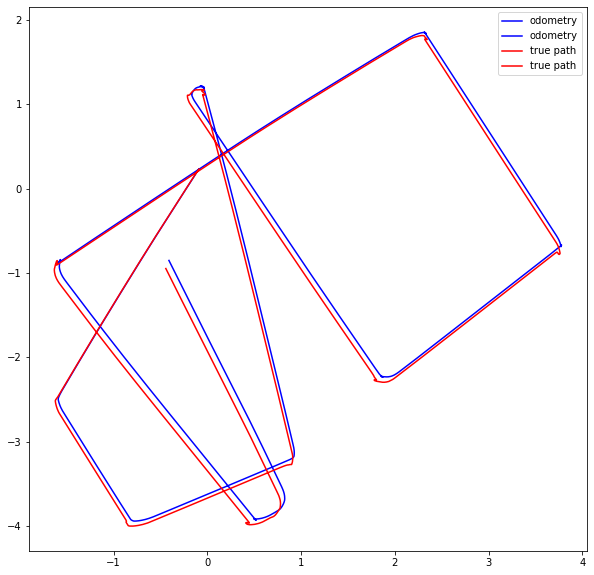

In [38]:
mr.kinematicModel.plot_paths()

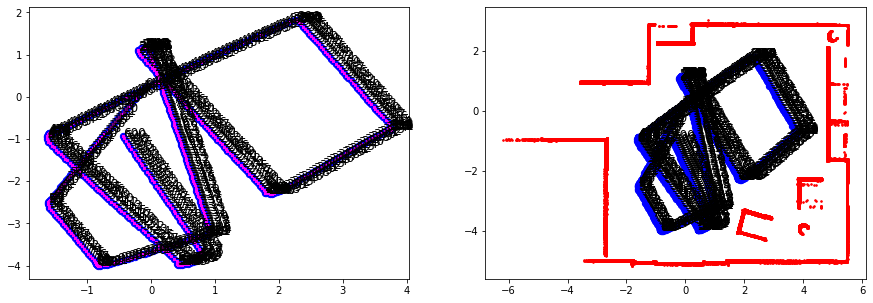

In [39]:
mr.point_cloud.plot_point_cloud()

The grid map is  35 x 26 .
17 13


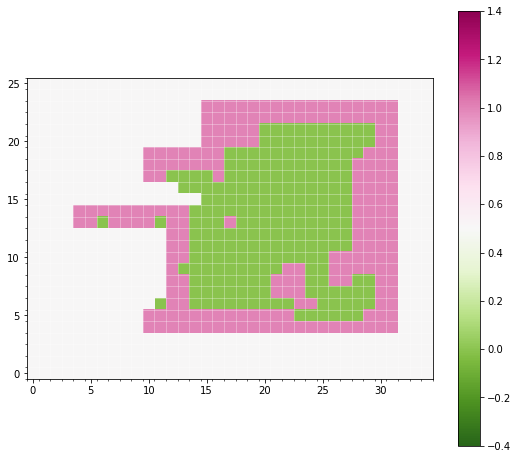

In [246]:
mr.point_cloud.set_resolution(0.455)
mr.point_cloud.compute_grid_ocupation()
mr.point_cloud.plot_grid_ocupation()

In [53]:
from sklearn import datasets, metrics
from sklearn.neural_network import MLPClassifier
import pyqlearning as pyq

In [136]:
import plotly.graph_objects as go
from plotly.colors import n_colors
import numpy as np

colors = n_colors('rgb(255, 200, 200)', 'rgb(200, 0, 0)', 9, colortype='rgb')

fig = go.Figure(data=[go.Table(
                 cells=dict(values=mr.point_cloud.pmap
                     ))])
fig.show()

x,y=mr.point_cloud.get_idx_from_pos(mr.point_cloud.robot_points[-1][0],mr.point_cloud.robot_points[-1][1])
print(x,y)
plt.ion()
fig, ax = plt.subplots()
ax.imshow(mr.point_cloud.pmap.T, cmap = "PiYG_r")
plt.clf()
i=0
while (i<10):
    #ax.cla()
    mr.point_cloud.pmap[x][y] = 0.5
    x = x + 1
    #plt.subplot(1,10,i+1)
    ax.imshow(mr.point_cloud.pmap.T, cmap = "PiYG_r")
    #ax.axis('off')
    #plt.draw()
    
    i = i+1
    time.sleep(1)
    
plt.draw()


17 13


<Figure size 432x288 with 0 Axes>

In [359]:
from enum import IntEnum

class Planning():

    def __init__(self):
        self.pmap = [[0,0],[0,0]]

    def find_zeros(self, pmap):
        l = 0
        c = 0
        zero = []
        pmap = np.array(pmap)
        for line in pmap:
            c = 0
            for column in line:
                if (column == 0):
                    zero.append([l,c])
                c = c + 1
            l = l + 1
        return zero
    
    def planning_path(self, pmap):
        path_points = []
        zero = self.find_zeros(pmap)
        last_point = zero[0] #define o ínicio do caminho
        l = zero[0][0]
        c = zero[0][1]
        numrows = len(pmap)
        numcols = len(pmap[0])
        for point in zero:
            if (point[0] != l):
                path_points.append(last_point)
                l = point[0]
                c = point[1]
                path_points.append([l,c])
            last_point = point
        ry = []
        rx = []
        
        for point in path_points:
            rx.append(point[0])
            ry.append(point[1])
        return rx, ry

    def plot_map(self, pmap):
        rx, ry = self.planning_path(pmap)
        ax, fig = plt.subplots(1,1)
        ax.clf()
        plt.cla()
        plt.imshow(np.transpose(pmap), cmap = "PiYG_r")
        plt.plot(rx, ry, label='path')
        plt.plot(rx[0], ry[0], marker='o', color='b', label='start')
        plt.plot(rx[-1],ry[-1], marker='o', color='r', label='end')
        plt.legend()
        plt.show()


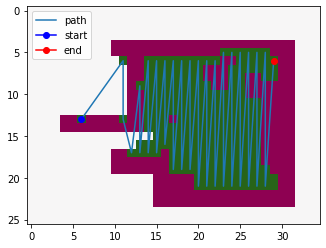

In [360]:
planning = Planning()
plan_plot = planning.plot_map(mr.point_cloud.pmap)

## Conclusão

<br>
Para o projeto ultilizamos os seguintes sensores:

* Encoders
* Sensores Ultrassônicos
* Laser Hokuyo
* Câmera
<br><br>
<div style="text-align: justify">
Os encoders foram utilizados para o processo de odometria, com os dados fornecidos por eles nós estimamos o deslocamento realizado pelo robô no ambiente. Já os sensores ultrassônicos utilizamos para detectar objetos que estivessem mais próximos do robô devido seu curto alcance, porém focamos na utilização do laser para criação da nuvem de pontos por apresentar uma maior precisão e alcance. A utilização da câmera durante o processo foi especificamente para depuração do código, durante a construção do mesmo utilizamos ela para ter uma melhor visão do que estava sendo observado pelo robô.
Como mencionado anteriormente os dados obtidos durante a coleta apresentam algumas variações em relação aos dados reais fornecidos pelo simulador V-REP (variações visíveis na odometria), estas variações são mais perceptíveis quando principalmente o robô realiza mudanças de direção, acreditamos que isto deve ocorrer pelo fato da imprecisão dos sensores (neste caso o encoder), o que gera um erro durante os cálculos de estimação de posição, tendo assim um acúmulo de erros durante todo o processo. Uma alternativa para a correção deste erro é a de utilização dos dados do laser como alternativa para minimização destes erros, onde poderíamos pegar pontos de referência na nuvem de pontos para calcularmos os ângulos de rotação e o deslocamento, porém o aperfeiçoamento deste modelo deve ser realizado somente na próxima etapa do trabalho.
</div>